In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import re

In [5]:
# read in restaurant data
rest = pd.read_csv('rest_data2.csv')

In [6]:
#set index to the restaurant name
rest = rest.set_index('name')

In [7]:
#remove restaurants with less than 30 ratings, as rating sample is too small to be accurate
rest = rest[rest.num_ratings>=30]

#get initial picture of resulting dataframe
print(rest.shape)
rest.describe()

(1013, 7)


,rating,quality_perc,ontime_perc,accuracy_perc,num_ratings,price
count,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,4.139684,84.242843,85.862784,88.996051,680.531096,2.364265
std,0.519848,8.606589,8.728668,7.765332,982.810176,0.585215
min,2.000000,43.000000,36.000000,39.000000,30.000000,0.000000
25%,4.000000,80.000000,82.000000,85.000000,98.000000,2.000000
50%,4.000000,86.000000,88.000000,91.000000,303.000000,2.000000
75%,4.500000,90.000000,92.000000,94.000000,815.000000,3.000000
max,5.000000,100.000000,100.000000,100.000000,9670.000000,4.000000


Text(0, 0.5, 'count')

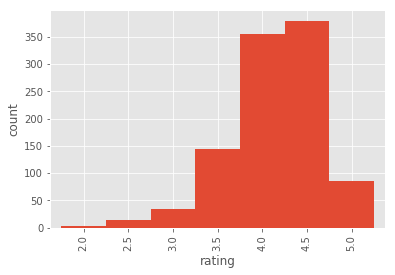

In [8]:
#inspect ratings distribution
rest.groupby('rating')['rating'].count().plot.bar(width=1.0)
plt.ylabel('count')

In [9]:
#cuisine category column was stored as a string and is converted to a list below
cats = rest.category.map(lambda x: x.split())

In [10]:
#replace category column with transformed version
rest['category']=cats

In [11]:
#define function to clean cuisine lists in the category column
def clean_cats(cat_lis):
    temp = []
    for x in cat_lis:
        try:
            cuis = re.search('[A-Z]+[a-z]*',x).group()
        except:
            cuis='blank'
        temp.append(cuis)
    return(temp)

In [12]:
#apply clean fucntion to the category column and reassign
final_cats = rest.category.map(lambda x: clean_cats(x))
rest['category']=final_cats

In [13]:
#find the restaurants with category values not matching the regex patter in clean_cats function
rest.loc[rest.category.map(lambda x: 'blank' in x)]

,rating,quality_perc,ontime_perc,accuracy_perc,num_ratings,price,category
name,,,,,,,
Creamline Burgers and Shakes,4.0,81,88,81,1189,3,[blank]


In [14]:
#manually replace the empty category for the only result
rest.category['Creamline Burgers and Shakes']=['Hamburgers']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
#create long form data frame with category stacked
exploded = rest.category.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'category'})

In [16]:
#set index in long form category frame to restaurant name
exploded.set_index('name', inplace=True)

In [17]:
#create new df with category dropped to merge with long form dataframe containing stacked categories
rest_lform = rest.drop('category',1)

In [18]:
#merge to create long form database
rest_lform = pd.merge(rest_lform, exploded, on='name')

In [19]:
#view counts for each food type and manually extract cuisine ethnicities with freq >30
#American, Japanese, Italian, Chinese, Mexican, Indian, Thai, Middle Easter
rest_lform.groupby('category')['rating'].agg(['mean','count'])\
      .sort_values('count', ascending = False)

,mean,count
category,,
Dinner,4.130966,901
Lunch,4.131148,793
Asian,4.327465,284
Sandwiches,4.018605,215
Breakfast,4.063776,196
Salads,4.030220,182
Healthy,4.076220,164
American,3.988189,127
Dessert,4.141026,117


In [20]:
#create list of cuisines of interest
cuisines = ['American', 'Japanese', 'Italian', 'Chinese', 'Mexican', 'Indian', 'Thai', 'Middle']

In [21]:
#prune long form data set to focus on cuisines of interest
lform_cuisines = rest_lform[rest_lform.category.isin(cuisines)]
lform_cuisines.groupby('category')['rating'].agg(['mean', 'std', 'count','median'])

,mean,std,count,median
category,,,,
American,3.988189,0.568570,127,4.0
Chinese,4.351648,0.508235,91,4.5
Indian,4.030612,0.562807,49,4.0
Italian,4.136364,0.514177,99,4.0
Japanese,4.426724,0.472064,116,4.5
Mexican,4.103774,0.483959,53,4.0
Middle,3.968750,0.567074,32,4.0
Thai,4.256410,0.471166,39,4.5


In [22]:
from scipy import stats

American = np.array(lform_cuisines[lform_cuisines.category=='American']['rating'])
Japanese = np.array(lform_cuisines[lform_cuisines.category=='Japanese']['rating'])
Italian = np.array(lform_cuisines[lform_cuisines.category=='Italian']['rating'])
Chinese = np.array(lform_cuisines[lform_cuisines.category=='Chinese']['rating'])
Mexican = np.array(lform_cuisines[lform_cuisines.category=='Mexican']['rating'])
Indian = np.array(lform_cuisines[lform_cuisines.category=='Indian']['rating'])
Thai = np.array(lform_cuisines[lform_cuisines.category=='Thai']['rating'])
Middle_Eastern = Indian = np.array(lform_cuisines[lform_cuisines.category=='Middle']['rating'])

In [23]:
#check that equality of variances condition holds, then perform one-way anova and kruskal-wallis
#ANOVA is likely better due to pseudo-interval data type
print(stats.bartlett(American, Japanese, Italian, Chinese, Mexican, Indian, Thai, Middle_Eastern))
print(stats.f_oneway(American, Japanese, Italian, Chinese, Mexican, Indian, Thai, Middle_Eastern))
stats.kruskal(American, Japanese, Italian, Chinese, Mexican, Indian, Thai, Middle_Eastern)
cuisines = [Japanese, American, Italian, Chinese, Mexican, Indian, Thai, Middle_Eastern]
for cuisine in cuisines:
    stats.ttest_ind(Japanese, cuisine)
for cuisine in cuisines:
    print(stats.ttest_ind(Italian, cuisine))

BartlettResult(statistic=6.405940365235973, pvalue=0.4932275386446985)
F_onewayResult(statistic=9.569291080911096, pvalue=2.7854512549811886e-11)
Ttest_indResult(statistic=-4.314180495130234, pvalue=2.4513791997641993e-05)
Ttest_indResult(statistic=2.026241537948783, pvalue=0.04392545729829508)
Ttest_indResult(statistic=0.0, pvalue=1.0)
Ttest_indResult(statistic=-2.89910422434987, pvalue=0.004187676859362651)
Ttest_indResult(statistic=0.3799867147708118, pvalue=0.7044927635965225)
Ttest_indResult(statistic=1.5629604626827474, pvalue=0.12051181286857007)
Ttest_indResult(statistic=-1.2635663799179429, pvalue=0.20854739924067328)
Ttest_indResult(statistic=1.5629604626827474, pvalue=0.12051181286857007)


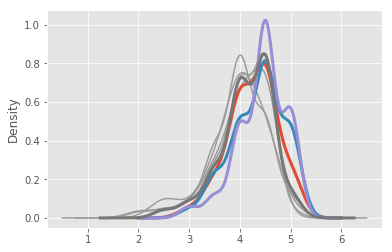

In [24]:
#potential highly stylized visualization of distributions by cuisine category
lform_cuisines[lform_cuisines.category=='American']['rating'].plot(kind='density',color = "#9a9c9a")
lform_cuisines[lform_cuisines.category=='Mexican']['rating'].plot(kind='density', color ="#9a9c9a")
lform_cuisines[lform_cuisines.category=='Indian']['rating'].plot(kind='density', color = "#9a9c9a")
lform_cuisines[lform_cuisines.category=='Middle']['rating'].plot(kind='density', color = "#9a9c9a")
lform_cuisines[lform_cuisines.category=='Thai']['rating'].plot(kind='density', linewidth=3)
lform_cuisines[lform_cuisines.category=='Chinese']['rating'].plot(kind='density', linewidth=3)
lform_cuisines[lform_cuisines.category=='Japanese']['rating'].plot(kind='density',linewidth=3)
lform_cuisines[lform_cuisines.category=='Italian']['rating'].plot(kind='density', linewidth=3)

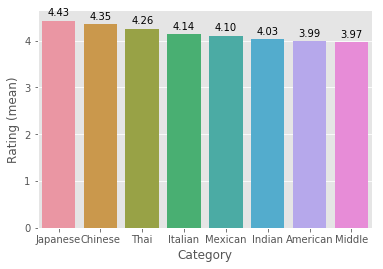

In [25]:
#generate plot showing mean rating by cuisine type
data = pd.DataFrame(lform_cuisines.groupby('category')['rating'].mean().sort_values(ascending=False))
data = data.reset_index(level=0)
plot = sns.barplot(x=data.category, y=data.rating)
for p in plot.patches:
    height = p.get_height()
    plot.text(p.get_x()+p.get_width()/2.,
            height+.1,
            '{:1.2f}'.format(height),
            ha="center") 
plot.set_xlabel("Category",fontsize=12)
plot.set_ylabel("Rating (mean)", fontsize=12)
sns.set_style({'text.color':'#000000'})
plt.show()

(0.6649219089203869, 2.83182921069712e-130)


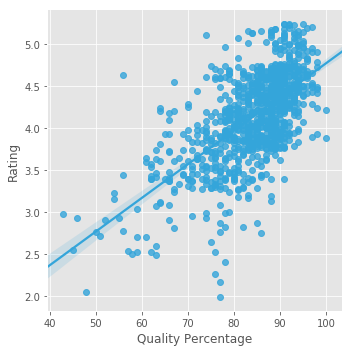

In [26]:
#generate plot showing correlation of quality and rating
sns.lmplot('quality_perc', 'rating', data=rest, y_jitter=0.25, line_kws={'color':'#34A5DA'}, scatter_kws={'color':'#34A5DA'})
plt.xlabel('Quality Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
print(stats.pearsonr(rest.quality_perc, rest.rating))

(0.542116626383485, 1.8585900518757827e-78)


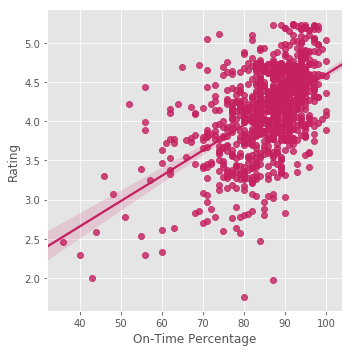

In [27]:
#generate plot showing correlation of order timeliness and rating
sns.lmplot('ontime_perc', 'rating', data=rest, y_jitter=0.25, line_kws={'color':'#C52060'}, scatter_kws={'color':'#C52060'})
plt.xlabel('On-Time Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
print(stats.pearsonr(rest.ontime_perc, rest.rating))

(0.5680358807796958, 1.3044915107344198e-87)


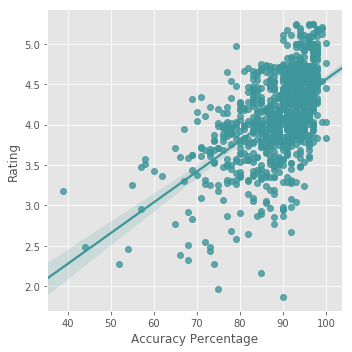

In [28]:
#generate plot showing correlation of order accuracy and rating
sns.lmplot('accuracy_perc', 'rating', data=rest, y_jitter=0.25, line_kws={'color':'#3F969A'}, scatter_kws={'color':'#3F969A'})
plt.xlabel('Accuracy Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
print(stats.pearsonr(rest.accuracy_perc, rest.rating))

In [29]:
corrdf = rest[['ontime_perc', 'accuracy_perc', 'quality_perc']]
corrdf.corr()

,ontime_perc,accuracy_perc,quality_perc
ontime_perc,1.000000,0.689684,0.706180
accuracy_perc,0.689684,1.000000,0.679322
quality_perc,0.706180,0.679322,1.000000


In [30]:
#create grouped data set to show distribution of ratings across food categories
grouped = pd.DataFrame(lform_cuisines.groupby(['category','rating'])['rating'].count())

In [31]:
#create grouped data set to show distribution of ratings across food categories (con't)
grouped = grouped.rename(columns={'rating':'count'})
grouped = grouped.reset_index(level=0)

In [32]:
#create grouped data set to show distribution of ratings across food categories (con't)
grouped = grouped.reset_index(level=0)

In [33]:
#add in missing null data so graph axes set correctly in facet grid
df = pd.DataFrame({'rating':[2.0,2.5,2.0,2.0,2.5,2.0,2.0,2.0,2.5,5], 'category':['Chinese','Chinese','Italian','Japanese','Japanese', 'Mexican','Middle', 'Thai','Thai','Indian'],'count':[0,0,0,0,0,0,0,0,0,0]})

In [34]:
#combine with previous grouped dataset
grouped_all = pd.concat([df, grouped])

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


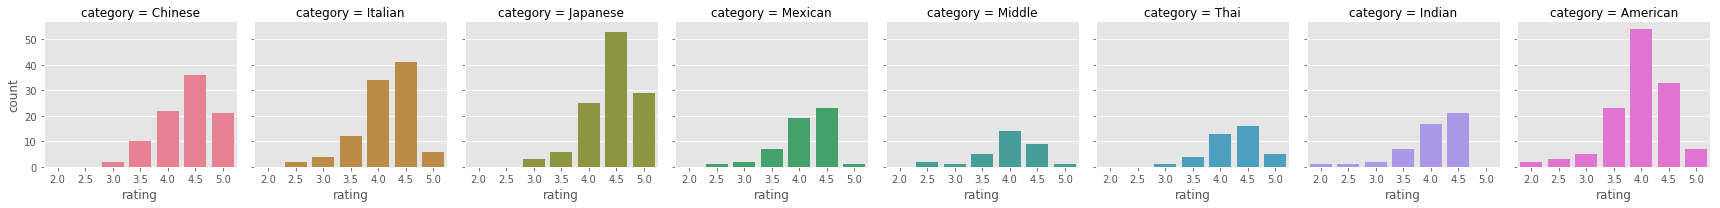

In [35]:
#develop facet grid graph
CatGrid = sns.FacetGrid(grouped_all, col='category', hue='category')
CatGrid.map(sns.barplot, 'rating', 'count')

(0.45361667976521647, 8.517292339923953e-08)
(0.6129444256814428, 1.0616363849382868e-10)


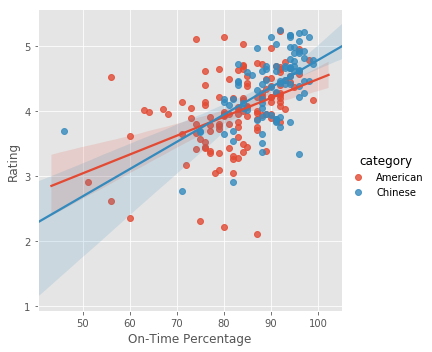

In [51]:
#generate plot showing correlation of timeliness and rating for two different cuisine types
sns.lmplot("ontime_perc", "rating", 
           lform_cuisines[lform_cuisines.category.isin(['Chinese','American'])], 
           hue="category", y_jitter=0.25)
plt.xlabel('On-Time Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
print(stats.pearsonr(lform_cuisines[lform_cuisines.category=='American']['ontime_perc'],
                        lform_cuisines[lform_cuisines.category=='American']['rating'] ))
print(stats.pearsonr(lform_cuisines[lform_cuisines.category=='Chinese']['ontime_perc'],
                        lform_cuisines[lform_cuisines.category=='Chinese']['rating'] ))

(0.6008750495806139, 8.121186946744117e-14)
(0.7094941349000228, 3.4953329140896965e-15)


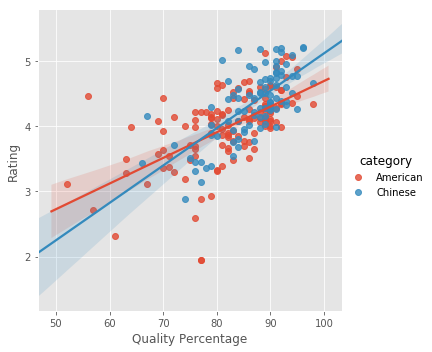

In [50]:
#generate plot showing correlation of quality and rating for two different cuisine types
sns.lmplot("quality_perc", "rating", 
           lform_cuisines[lform_cuisines.category.isin(['Chinese','American'])], 
           hue="category", y_jitter=0.25)
plt.xlabel('Quality Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
print(stats.pearsonr(lform_cuisines[lform_cuisines.category=='American']['quality_perc'],
                        lform_cuisines[lform_cuisines.category=='American']['rating'] ))
print(stats.pearsonr(lform_cuisines[lform_cuisines.category=='Chinese']['quality_perc'],
                        lform_cuisines[lform_cuisines.category=='Chinese']['rating'] ))

(0.5080211896157039, 1.0827147212064084e-09)
(0.7110126030472049, 2.8739245138523773e-15)


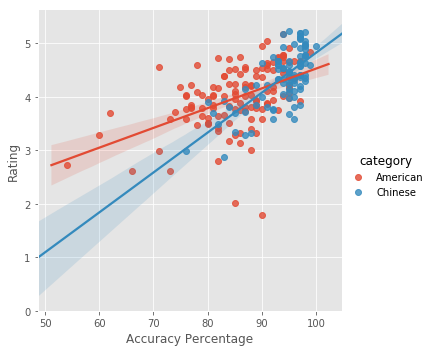

In [49]:
#generate plot showing correlation of accuracy and rating for two different cuisine types
sns.lmplot("accuracy_perc", "rating", 
           lform_cuisines[lform_cuisines.category.isin(['Chinese','American'])], 
           hue="category", y_jitter=0.25)
plt.xlabel('Accuracy Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
print(stats.pearsonr(lform_cuisines[lform_cuisines.category=='American']['accuracy_perc'],
                        lform_cuisines[lform_cuisines.category=='American']['rating'] ))
print(stats.pearsonr(lform_cuisines[lform_cuisines.category=='Chinese']['accuracy_perc'],
                        lform_cuisines[lform_cuisines.category=='Chinese']['rating'] ))